In [1]:
# Env: rive
# Audrey / Cindy /
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import proplot as pplt # New plot library (https://proplot.readthedocs.io/en/latest/)
pplt.rc['savefig.dpi'] = 300 # 1200 is too big! #https://proplot.readthedocs.io/en/latest/basics.html#Creating-figures
from scipy import stats
import xesmf as xe # For regridding (https://xesmf.readthedocs.io/en/latest/)
import calendar
import os
import tensorflow as tf # Machine learning

2024-01-12 15:54:34.735391: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import MeanSquaredError, MeanAbsoluteError
import tensorflow.keras.backend as K
import pandas as pd
import numpy as np

# Chargement des librairies + données
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [3]:
echantillons = pd.read_csv("../AtlasDeLEau/qualite_eau_complet.csv", dtype={'no_labo': 'string', 'no_station': 'string'})

In [4]:
echantillons

,no_labo,no_projet,no_station,date,heure,alc,cat,cf,chl_aa,clo,...,V-S (mg/l),ZN-S (mg/l),P-T-660 (µg/l),CF-C (UFC/100 ml),AS (mg/l),PHE (µg/l),TAN (mg/l),AG (mg/l),U (mg/l),P-T-66V (µg/l)
0,74390,220,0000097A,2000-05-16T00:00:00Z,1145,NaN,NaN,130.0,1.70,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,76610,220,0000097A,2000-06-19T00:00:00Z,1240,NaN,NaN,70.0,1.95,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,78452,220,0000097A,2000-07-11T00:00:00Z,1450,NaN,NaN,270.0,1.50,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,82191,220,0000097A,2000-08-15T00:00:00Z,1430,NaN,NaN,170.0,1.56,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,85252,220,0000097A,2000-09-20T00:00:00Z,1215,NaN,NaN,340.0,1.08,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132717,Q120594-63,210,07710001,2020-07-14T00:00:00Z,1326,NaN,10.0,260.0,1.98,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
132718,Q121526-38,210,07710001,2020-08-11T00:00:00Z,1627,NaN,12.0,900.0,1.60,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
132719,Q122605-93,210,07710001,2020-09-15T00:00:00Z,9999,NaN,15.0,100.0,1.40,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
132720,Q123335-18,210,07710001,2020-10-13T00:00:00Z,1600,NaN,10.0,11.0,0.56,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
cible = "turb"

#echantillons = pd.read_csv("../AtlasDeLEau/qualite_eau_complet.csv")
echantillons = pd.read_csv("../AtlasDeLEau/qualite_eau_complet.csv", dtype={'no_labo': 'string', 'no_station': 'string'})


qualite_eau = echantillons.copy()
qualite_eau['annee'] = pd.to_datetime(qualite_eau['date']).dt.year
qualite_eau['mois'] = pd.to_datetime(qualite_eau['date']).dt.month
qualite_eau = qualite_eau[(qualite_eau['mois'] >= 6) & (qualite_eau['mois'] <= 9) & (qualite_eau['annee'] >= 2016)]
qualite_eau['ID'] = qualite_eau['no_station'].astype(str) + "_" + qualite_eau['annee'].astype(str)
qualite_eau['nom_fichier'] = qualite_eau['ID'] + ".png"
qualite_eau = qualite_eau.dropna(subset=[cible])
qualite_eau[cible] = StandardScaler().fit_transform(qualite_eau[[cible]])

In [6]:
qualite_eau[cible]

19812    -0.224416
19813     0.038005
19814     0.084044
19819     0.130083
19820     1.373133
            ...   
132713    0.222161
132714    0.038005
132717    0.820666
132718    0.728589
132719   -0.026449
Name: turb, Length: 9372, dtype: float64

In [7]:
qualite_eau

,no_labo,no_projet,no_station,date,heure,alc,cat,cf,chl_aa,clo,...,AS (mg/l),PHE (µg/l),TAN (mg/l),AG (mg/l),U (mg/l),P-T-66V (µg/l),annee,mois,ID,nom_fichier
19812,Q111972-99,210,06130005,2019-06-10T00:00:00Z,1000,NaN,18.0,3.0,4.73,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2019,6,06130005_2019,06130005_2019.png
19813,Q113254-06,210,06130005,2019-07-15T00:00:00Z,1010,NaN,27.0,5.0,4.51,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2019,7,06130005_2019,06130005_2019.png
19814,Q114228-99,210,06130005,2019-08-06T00:00:00Z,950,NaN,27.0,52.0,3.17,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2019,8,06130005_2019,06130005_2019.png
19819,Q120460-13,210,06130005,2020-07-13T00:00:00Z,1015,NaN,26.0,52.0,4.58,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2020,7,06130005_2020,06130005_2020.png
19820,Q122442-21,210,06130005,2020-09-14T00:00:00Z,700,NaN,27.0,84.0,4.58,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2020,9,06130005_2020,06130005_2020.png
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132713,Q114611-97,210,07710001,2019-08-13T00:00:00Z,912,NaN,15.0,430.0,2.28,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2019,8,07710001_2019,07710001_2019.png
132714,Q115919-20,210,07710001,2019-09-18T00:00:00Z,845,NaN,17.0,54.0,2.06,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2019,9,07710001_2019,07710001_2019.png
132717,Q120594-63,210,07710001,2020-07-14T00:00:00Z,1326,NaN,10.0,260.0,1.98,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2020,7,07710001_2020,07710001_2020.png
132718,Q121526-38,210,07710001,2020-08-11T00:00:00Z,1627,NaN,12.0,900.0,1.60,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2020,8,07710001_2020,07710001_2020.png


In [8]:
# Préparation des générateurs d'images
dossier_images = "../Imagerie/3km/"
colonne_noms_fichiers = "nom_fichier"
rescale_factor = 1/255
validation_fraction = 0.2
image_dimensions = (294, 201)
random_seed = int(np.round(np.random.uniform(0, 10000)))

train_data, val_data = train_test_split(qualite_eau, test_size=validation_fraction, random_state=random_seed)

In [9]:
train_data

,no_labo,no_projet,no_station,date,heure,alc,cat,cf,chl_aa,clo,...,AS (mg/l),PHE (µg/l),TAN (mg/l),AG (mg/l),U (mg/l),P-T-66V (µg/l),annee,mois,ID,nom_fichier
99502,Q107057-72,210,03030094,2018-09-04T00:00:00Z,1500,NaN,NaN,11.0,12.50,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2018,9,03030094_2018,03030094_2018.png
132201,Q104075-44,210,05260015,2018-06-11T00:00:00Z,1156,NaN,NaN,11.0,1.60,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2018,6,05260015_2018,05260015_2018.png
100452,Q103714-23,210,02390001,2018-06-04T00:00:00Z,1205,NaN,NaN,50.0,4.08,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2018,6,02390001_2018,02390001_2018.png
125806,Q098075-12,210,01150047,2017-08-08T00:00:00Z,815,NaN,NaN,54.0,0.52,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2017,8,01150047_2017,01150047_2017.png
130062,Q107239-43,210,06230002,2018-09-10T00:00:00Z,845,NaN,NaN,2900.0,1.02,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2018,9,06230002_2018,06230002_2018.png
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121827,Q088582-55,210,03010009,2016-06-07T00:00:00Z,930,NaN,NaN,600.0,7.32,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2016,6,03010009_2016,03010009_2016.png
71945,Q130324-06,230,05250004,2021-09-14T00:00:00Z,1205,NaN,NaN,120.0,0.99,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2021,9,05250004_2021,05250004_2021.png
129685,Q113726-78,210,05220012,2019-07-23T00:00:00Z,915,NaN,9.9,18.0,1.31,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2019,7,05220012_2019,05220012_2019.png
129969,Q107171-33,210,05400006,2018-09-10T00:00:00Z,1118,NaN,NaN,120.0,0.79,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2018,9,05400006_2018,05400006_2018.png


In [10]:
val_data

,no_labo,no_projet,no_station,date,heure,alc,cat,cf,chl_aa,clo,...,AS (mg/l),PHE (µg/l),TAN (mg/l),AG (mg/l),U (mg/l),P-T-66V (µg/l),annee,mois,ID,nom_fichier
72543,Q115919-19,210,07040001,2019-09-17T00:00:00Z,1425,NaN,NaN,5.0,0.68,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2019,9,07040001_2019,07040001_2019.png
67165,Q121453-09,210,02360014,2020-08-10T00:00:00Z,615,NaN,29.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2020,8,02360014_2020,02360014_2020.png
131502,Q122567-16,210,04010002,2020-09-15T00:00:00Z,1110,NaN,21.0,600.0,1.90,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2020,9,04010002_2020,04010002_2020.png
93992,Q113126-37,210,02280003,2019-07-10T00:00:00Z,1400,NaN,NaN,10.0,4.27,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2019,7,02280003_2019,02280003_2019.png
69144,Q114359-94,210,03040071,2019-08-06T00:00:00Z,1625,NaN,NaN,48.0,2.41,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2019,8,03040071_2019,03040071_2019.png
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61807,Q089472-54,210,03010012,2016-07-05T00:00:00Z,920,NaN,NaN,10.0,2.97,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2016,7,03010012_2016,03010012_2016.png
64874,Q104816-07,210,03090003,2018-07-03T00:00:00Z,1545,NaN,NaN,46.0,1.36,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2018,7,03090003_2018,03090003_2018.png
64082,Q107398-72,210,05120021,2018-09-17T00:00:00Z,915,NaN,NaN,15.0,1.12,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2018,9,05120021_2018,05120021_2018.png
127689,Q106330-37,210,05050100,2018-08-14T00:00:00Z,1305,NaN,NaN,88.0,5.52,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2018,8,05050100_2018,05050100_2018.png


In [11]:
datagen = ImageDataGenerator(rescale=rescale_factor)

training_generator = datagen.flow_from_dataframe(
    train_data,
    directory=dossier_images,
    x_col=colonne_noms_fichiers,
    y_col=cible,
    target_size=image_dimensions,
    class_mode="other",
    #subset="training",
    seed=random_seed
)

validation_generator = datagen.flow_from_dataframe(
    val_data,
    directory=dossier_images,
    x_col=colonne_noms_fichiers,
    y_col=cible,
    target_size=image_dimensions,
    class_mode="other",
    #subset="validation",
    seed=random_seed
)

Found 7497 validated image filenames.
Found 1875 validated image filenames.


In [12]:
# Préparation et ajustement du modèle
model = Sequential([
    Conv2D(128, kernel_size=(3, 3), activation="relu", input_shape=(image_dimensions[0], image_dimensions[1], 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(32, kernel_size=(3, 3), activation="relu"),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(32, kernel_size=(3, 3), activation="relu"),
    MaxPooling2D(pool_size=(4, 4)),
    Flatten(),
    Dense(64, activation="relu"),
    Dense(1)
])

def r2(y_true, y_pred):
    SS_res = K.sum(K.square(y_true - y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return 1 - SS_res / (SS_tot + K.epsilon())

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 292, 199, 128)     3584      
                                                                 
 max_pooling2d (MaxPooling2  (None, 146, 99, 128)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 144, 97, 32)       36896     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 72, 48, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 70, 46, 32)        9248      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 11, 32)        0

In [13]:
model.compile(optimizer="adam", loss="mse", metrics=["mae", r2])

In [25]:
# Exploration des résultats
history = model.fit(
    x=training_generator,
    validation_data=validation_generator,
    epochs=5
)

Epoch 1/5
235/235 [==============================] - 774s 3s/step - loss: 0.9412 - mae: 0.4552 - r2: -0.1205 - val_loss: 1.2352 - val_mae: 0.4438 - val_r2: -0.0315
Epoch 2/5
235/235 [==============================] - 414s 2s/step - loss: 0.8967 - mae: 0.4220 - r2: -0.1361 - val_loss: 1.0712 - val_mae: 0.3707 - val_r2: 0.1541
Epoch 3/5
235/235 [==============================] - 419s 2s/step - loss: 0.7785 - mae: 0.3668 - r2: 0.0702 - val_loss: 0.9831 - val_mae: 0.3405 - val_r2: 0.1761
Epoch 4/5
235/235 [==============================] - 418s 2s/step - loss: 0.7386 - mae: 0.3583 - r2: 0.0644 - val_loss: 0.9980 - val_mae: 0.3283 - val_r2: 0.2313
Epoch 5/5
235/235 [==============================] - 416s 2s/step - loss: 0.7070 - mae: 0.3418 - r2: 0.1509 - val_loss: 0.9313 - val_mae: 0.3135 - val_r2: 0.2467


In [26]:
# Exploration des résultats
history = model.fit(
    x=training_generator,
    validation_data=validation_generator,
    epochs=50
)

Epoch 1/50
235/235 [==============================] - 400s 2s/step - loss: 0.6840 - mae: 0.3345 - r2: 0.1280 - val_loss: 0.9166 - val_mae: 0.3087 - val_r2: 0.2861
Epoch 2/50
235/235 [==============================] - 409s 2s/step - loss: 0.6766 - mae: 0.3352 - r2: 0.1007 - val_loss: 0.9534 - val_mae: 0.3059 - val_r2: 0.3077
Epoch 3/50
235/235 [==============================] - 412s 2s/step - loss: 0.6656 - mae: 0.3265 - r2: 0.1580 - val_loss: 0.9213 - val_mae: 0.3487 - val_r2: 0.1647
Epoch 4/50
235/235 [==============================] - 412s 2s/step - loss: 0.6540 - mae: 0.3257 - r2: 0.0861 - val_loss: 0.9573 - val_mae: 0.3496 - val_r2: 0.2185
Epoch 5/50
235/235 [==============================] - 412s 2s/step - loss: 0.6603 - mae: 0.3208 - r2: 0.0967 - val_loss: 0.9073 - val_mae: 0.3204 - val_r2: 0.3304
Epoch 6/50
235/235 [==============================] - 532s 2s/step - loss: 0.6346 - mae: 0.3154 - r2: 0.0757 - val_loss: 0.9415 - val_mae: 0.3049 - val_r2: 0.3362
Epoch 7/50
235/235 [==

In [27]:
history.history

{'loss': [0.6839897036552429,
  0.6765545010566711,
  0.6655589938163757,
  0.6540011763572693,
  0.6602943539619446,
  0.6345669627189636,
  0.632473349571228,
  0.6256186962127686,
  0.632263720035553,
  0.6211528182029724,
  0.6251247525215149,
  0.6112632751464844,
  0.5961160659790039,
  0.6198533177375793,
  0.5983589291572571,
  0.5977132320404053,
  0.607789158821106,
  0.5973628163337708,
  0.5889366865158081,
  0.5814290046691895,
  0.5787407159805298,
  0.6196823716163635,
  0.5806400775909424,
  0.5787475109100342,
  0.5743381381034851,
  0.5833465456962585,
  0.5771048665046692,
  0.5711276531219482,
  0.5761459469795227,
  0.5689041018486023,
  0.5693126320838928,
  0.5729815363883972,
  0.5663501024246216,
  0.5647853016853333,
  0.5677021741867065,
  0.5603429079055786,
  0.5652531981468201,
  0.5656680464744568,
  0.5698848962783813,
  0.5603875517845154,
  0.5434600114822388,
  0.5590065717697144,
  0.5484042763710022,
  0.5502886772155762,
  0.546407163143158,
  0.56

Text(0.5, 0.98, 'Predict turbidity from 3km images (M3)')

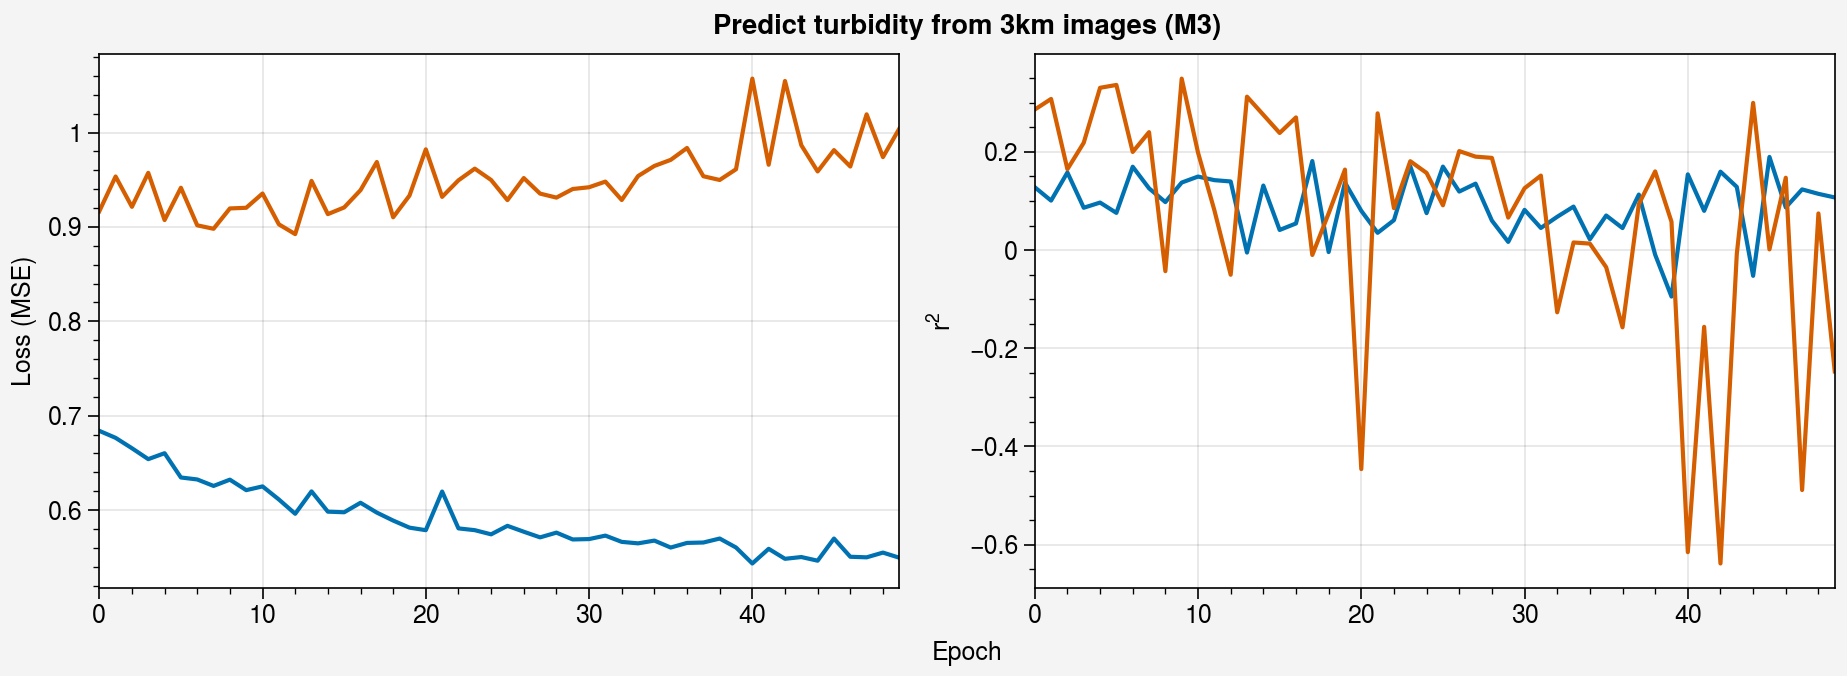

In [36]:
fig, axs = pplt.subplots(ncols=2, nrows=1, refwidth=4, sharey=0, refaspect=1.5)

axs[0].plot(history.history['loss'], label='training')
axs[0].plot(history.history['val_loss'], label='validation')
axs[0].format(xlabel='Epoch', ylabel='Loss (MSE)')

axs[1].plot(history.history['r2'], label='training')
axs[1].plot(history.history['val_r2'], label='validation')
axs[1].format(xlabel='Epoch', ylabel='$r^2$')

fig.suptitle('Predict turbidity from 3km images (M3)')

In [34]:
import pickle

In [15]:
name = 'qualite_eau_M3_3km'

In [35]:
with open('trainHistoryDict/'+name+'.pkl', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

In [38]:
model.save_weights('weights/'+name+'.h5')

In [16]:
model.load_weights('weights/'+name+'.h5')

In [ ]:
with open('/trainHistoryDict', "rb") as file_pi:
    history = pickle.load(file_pi)

In [18]:
predict_train = model.predict(training_generator)

235/235 [==============================] - 117s 498ms/step


In [19]:
predict_val = model.predict(validation_generator)

59/59 [==============================] - 27s 459ms/step


In [20]:
predict_train

array([[-0.07901348],
       [-0.2576911 ],
       [-0.14526625],
       ...,
       [-0.30782372],
       [-0.06362456],
       [ 0.4679327 ]], dtype=float32)

In [22]:
train_data[cible]

99502    -0.279663
132201   -0.413176
100452   -0.008033
125806   -0.426987
130062   -0.054072
            ...   
121827    1.235016
71945    -0.348721
129685   -0.164566
129969   -0.339513
71209    -0.403968
Name: turb, Length: 7497, dtype: float64

In [24]:
stats.linregress(predict_train.squeeze(), train_data[cible])

LinregressResult(slope=-0.007126195707373343, intercept=-0.009500867522350163, rvalue=-0.0049546866145519005, pvalue=0.6679714604691734, stderr=0.016613089525656183, intercept_stderr=0.011149774128132912)

In [26]:
stats.linregress(predict_val.squeeze(), val_data[cible])

LinregressResult(slope=-0.03476885468260505, intercept=0.04177567925559974, rvalue=-0.023273843540181225, pvalue=0.31381400182954566, stderr=0.03450926673545889, intercept_stderr=0.026360560957149125)

ValueError: x and y must be the same size

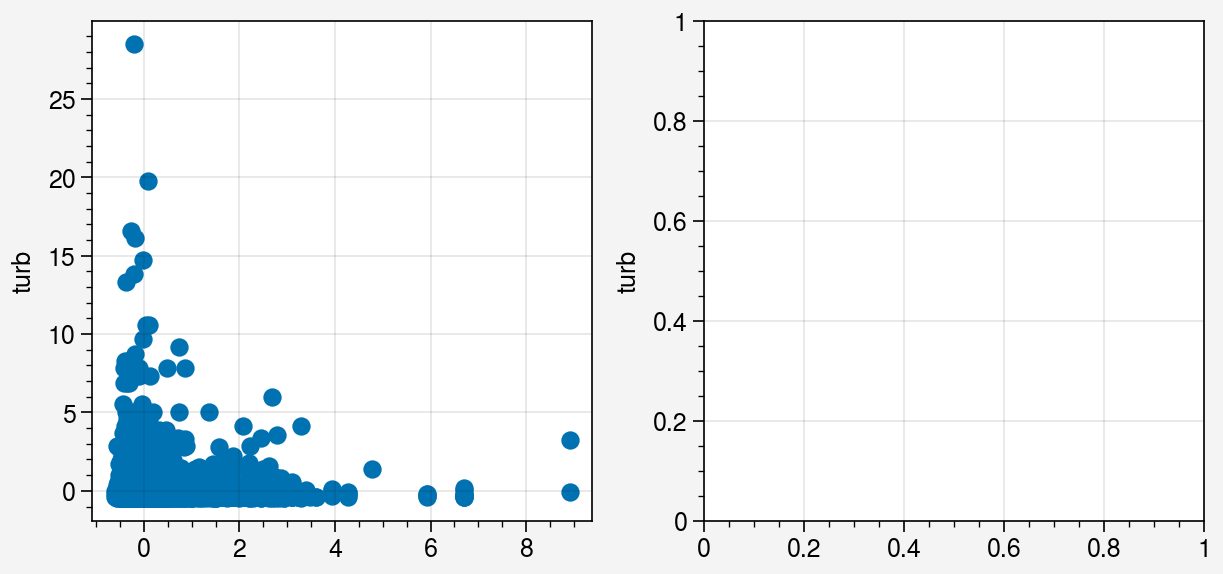

In [23]:
fig, axs = pplt.subplots(ncols=2, share=0)

axs[0].scatter(predict_train, train_data[cible])
axs[1].scatter(predict_val, train_data[cible])

# # Make linear trend for models values and compute pearsonr
# reg_train = stats.linregress(predict_train.squeeze(), y_train_arr.squeeze())
# reg_val = stats.linregress(predict_val.squeeze(), y_val_arr.squeeze())

# x = pplt.arange(0, predict_train.max())
# y = reg_train.slope*x + reg_train.intercept
# axs[0].plot(x, y, 'k-', linewidth=0.8, alpha=0.8)
# axs[0].format(lrtitle='$r^2$ = ' + str(round(reg_train.rvalue**2, 2)) + ' (%.2f)' % round(reg_train.pvalue, 2))

# x = pplt.arange(0, predict_val.max())
# y = reg_train.slope*x + reg_val.intercept
# axs[1].plot(x, y, 'k-', linewidth=0.8, alpha=0.8)
# axs[1].format(lrtitle='$r^2$ = ' + str(round(reg_val.rvalue**2, 2)) + ' (%.2f)' % round(reg_val.pvalue, 2))

# axs[0].format(title='Training (128)', xlabel='Predicted COD (mg/L)', ylabel='Observed COD (mg/L)')
# axs[1].format(title='Validation (43)', xlabel='Predicted COD (mg/L)', ylabel='Observed COD (mg/L)')

# fig.suptitle('Carbone organique dissout (MLP)')
# fig.save('../img/corr_MLP.jpg')


